In [ ]:
# https://www.swisstransfer.com/d/e51ca97e-61f6-4932-870f-b8176e3f637c lien fichier donner intermédiare

In [ ]:

"""
Created on Mon Nov 11 11:56:50 2024

@author: thomas choussat
"""



import pandas as pd
import numpy as np
import sklearn as sk
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from shapely.geometry import Point
from scipy.spatial import cKDTree
import pickle
#
#https://www.data.gouv.fr/fr/datasets/base-nationale-de-gestion-assistee-des-procedures-administratives-relatives-aux-risques-gaspar
#https://www.data.gouv.fr/fr/datasets/contours-des-communes-de-france-simplifie-avec-regions-et-departement-doutre-mer-rapproches/
#https://www.data.gouv.fr/fr/datasets/donnees-changement-climatique-sim-mensuelle/

# Lecture des données
CAT= pd.read_csv("data/CATNAT.csv")
Commune = gpd.read_file("data/commune.json" )    
df4 = pd.read_csv('data\MENS_SIM2_2010-2019.csv',delimiter=';' )
df5 = pd.read_csv('data\MENS_SIM2_latest-2020-2024.csv',delimiter=';' )

df3 = pd.read_csv('data\MENS_SIM2_2000-2009.csv',delimiter=';')
df2 = pd.read_csv('data\MENS_SIM2_1990-1999.csv',delimiter=';')
df1 = pd.read_csv('data\MENS_SIM2_1980-1989.csv',delimiter=';')
data=pd.concat([df1,df2,df3,df4,df5] ,ignore_index=True)
del df1, df2, df3, df4 ,df5
# On limite les donnée qu'on utilise
CAT = CAT.drop(columns=['cod_nat_catnat', 'num_risque_jo', 'dat_pub_jo', 'dat_maj'])
Commune = Commune.drop(columns=[ 'id', 'xcl2154', 'ycl2154'])
data = data.drop(columns=["SSWI1_MENS","SSWI6_MENS","SSWI12_MENS"])
dates = pd.date_range(end="2022-12-31", periods=60, freq='M')
CAT['dat_fin'] = pd.to_datetime(CAT['dat_fin'])
CAT['dat_deb'] = pd.to_datetime(CAT['dat_deb'])
CAT['dat_pub_arrete'] = pd.to_datetime(CAT['dat_pub_arrete'])
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m')

#%%
data["KEY"] = data['LAMBY'].apply(str).str.cat( data['LAMBX'].apply(str), sep=",")
# On garde que les donnée que l'on veux garder
CAT = CAT[CAT['dat_fin']>=min(dates) ]
dates = pd.DataFrame(dates)
# On crée notre base de donnée
Communes = Commune.merge(dates, how='cross')
Communes = Communes.rename(columns={0: "DATE"})
Communes["dry"] = 0

#On implimante nos catasphrophe , code assez long ~30mn a tournée
i=0;
for code in pd.unique(Communes["codgeo"]):
    i+=1
    # Filter CAT for the current code
    CATNAT = CAT[CAT["cod_commune"] == code]
    if i%500==0:
        print(i)
    if len(CATNAT) > 0:
        sample = Communes[Communes["codgeo"] == code]

        for idx_catnat, row_catnat in CATNAT.iterrows():
            # Check if sample['DATE'] is within the date range [dat_deb, dat_fin]
            condition = sample["DATE"].between(row_catnat["dat_deb"], row_catnat["dat_fin"])

            # Update 'dry' to 1 where condition is True
            Communes.loc[sample[condition].index, "dry"] = 1

#Recuper les résultat précedent pour éviter d'avoir a refaire tourner le code
#Communes=pd.read_pickle("CommunesCopy")
#%Communes=Communes.rename(columns= {"geometry" : "formeCommune" })



data2=data
geometry = [Point(xy) for xy in zip(data2["LAMBX"], data2["LAMBY"])]

# Étape 2: Créer un GeoDataFrame avec le CRS Lambert 93
gdf = gpd.GeoDataFrame(data2, geometry=geometry, crs="EPSG:2154")  # EPSG:2154 correspond à Lambert 93

# Étape 3: Reprojeter en WGS 84 (EPSG:4326)
gdf_wgs84 = gdf.to_crs(epsg=4326)  # EPSG:4326 correspond à WGS 84



def nearest_temperature_by_time(ville, temperature, date_col_ville, date_col_temp):
    """
    Associe chaque Polygon de `ville` au point de `temperature` le plus proche,
    en tenant compte de la proximité spatiale et du même mois/année.
    """
    # Extraire année et mois
    ville["year_month"] = pd.to_datetime(ville[date_col_ville]).dt.to_period("M")
    temperature["year_month"] = pd.to_datetime(temperature[date_col_temp]).dt.to_period("M")

    # Préparer un GeoDataFrame de résultats
    results = []

    # Pour chaque groupe de `year_month` dans `ville`
    for period, ville_group in ville.groupby("year_month"):
        # Filtrer temperature pour le même mois et année
        temp_group = temperature[temperature["year_month"] == period]
        
        if temp_group.empty:
            # Si pas de correspondance temporelle, ignorer ce groupe
            continue

        # Filtrer les géométries non valides dans `ville_group` et `temp_group`
        ville_group = ville_group[ville_group.geometry.notnull()]
        temp_group = temp_group[temp_group.geometry.notnull()]

        temp_group = temp_group[temp_group.geometry.geom_type == "Point"]

        # Calculer les centroïdes pour les Polygons dans `ville_group`
        ville_group = ville_group.copy()
        ville_group["centroid"] = ville_group.geometry.centroid

        # Vérifier si les groupes sont toujours non vides après le filtrage
        if ville_group.empty or temp_group.empty:
            continue

        # Construire un arbre spatial pour les points de `temp_group`
        temp_coords = list(zip(temp_group.geometry.x, temp_group.geometry.y))
        temp_tree = cKDTree(temp_coords)

        # Obtenir les coordonnées des centroïdes de `ville_group`
        ville_coords = list(zip(ville_group["centroid"].x, ville_group["centroid"].y))

        # Trouver les plus proches voisins
        distances, indices = temp_tree.query(ville_coords, k=1)

        # Enregistrer les résultats pour ce groupe
        ville_group["nearest_temp_index"] = temp_group.index.values[indices]
        ville_group["distance_to_temp"] = distances

        results.append(ville_group)

    # Combiner tous les résultats
    enriched_ville = pd.concat(results, ignore_index=True)

    # Fusionner toutes les variables de température dans le GeoDataFrame enrichi
    enriched_ville = enriched_ville.merge(
        temperature, 
        left_on="nearest_temp_index", 
        right_index=True, 
        suffixes=("_ville", "_temp")
    )

    return enriched_ville


w = nearest_temperature_by_time(Communes,gdf_wgs84,"DATE","DATE")
w = w.drop(columns=['SPI1_MENS','SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS', 'SSWI3_MENS', 'ECOULEMENT_MENS','KEY','year_month_ville', 'centroid', 'nearest_temp_index','distance_to_temp', 'LAMBX', 'LAMBY'])
data = w
data=data.drop(columns=['geometry_temp'])
data.to_file("output.gpkg", layer='geometry_ville', driver="GPKG")

In [2]:
cd Documents/GitHub/Project_M2/ml/

[WinError 3] Le chemin d’accès spécifié est introuvable: 'Documents/GitHub/Project_M2/ml/'
C:\Users\yacko\Documents\GitHub\Project_M2\ml


In [3]:
data = gpd.read_file("output.gpkg")
print("Done")

Done


In [5]:
data.columns

Index(['codgeo', 'reg', 'libgeo', 'DATE_ville', 'dry', 'DATE_temp',
       'PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS', 'EVAP_MENS',
       'ETP_MENS', 'PE_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS',
       'year_month_temp', 'geometry'],
      dtype='object')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que `data` soit votre DataFrame

# Calculer les proportions de `dry = 1` et `dry = 0`
dry_counts = data['dry'].value_counts(normalize=True) * 100

# Créer un bar plot des proportions de `dry`
plt.figure(figsize=(8, 6), facecolor='beige')
dry_counts.plot(kind='bar', color=['orange', 'skyblue'], alpha=0.6)
plt.xlabel('Valeur de dry')
plt.ylabel('Proportion (%)')
plt.title('Proportion de dry = 1 et dry = 0')
plt.xticks([0, 1], ['dry = 0', 'dry = 1'])
plt.ylim(0, 100)

# Enlever la grille et les bordures du graphique
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


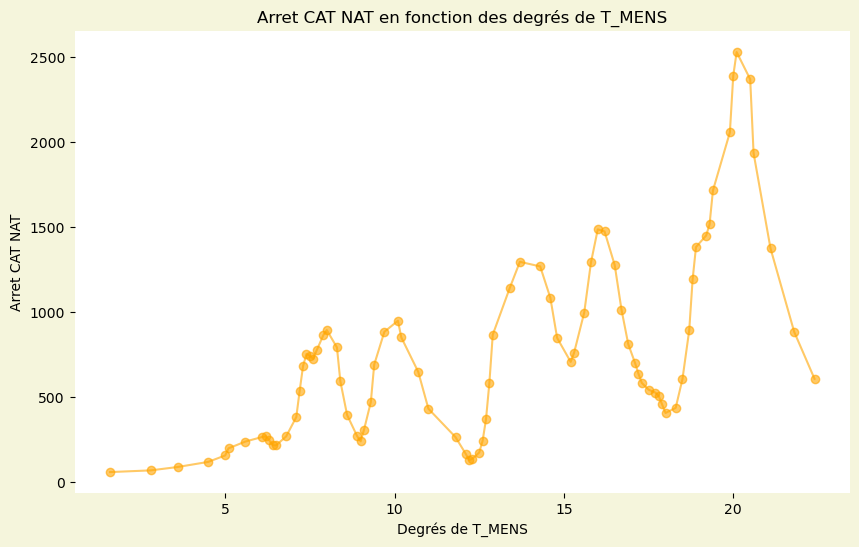

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Supposons que `data` soit votre DataFrame

# Compter le nombre de fois où `dry` est égal à 1 pour chaque valeur unique de `T_MENS`
dry_counts = data[data['dry'] == 1]['T_MENS'].value_counts().sort_index()

# Lisser les données avec un filtre gaussien
smooth_dry_counts = gaussian_filter1d(dry_counts.values, sigma=2)

# Créer un graphique des degrés de 'T_MENS' et le nombre de 'dry' = 1
plt.figure(figsize=(10, 6), facecolor='beige')
plt.plot(dry_counts.index, smooth_dry_counts, marker='o', linestyle='-', color='orange', alpha=0.6)
plt.xlabel('Degrés de T_MENS')
plt.ylabel('Arret CAT NAT')
plt.title('Arret CAT NAT en fonction des degrés de T_MENS')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Enlever la grille et les bordures du graphique
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()



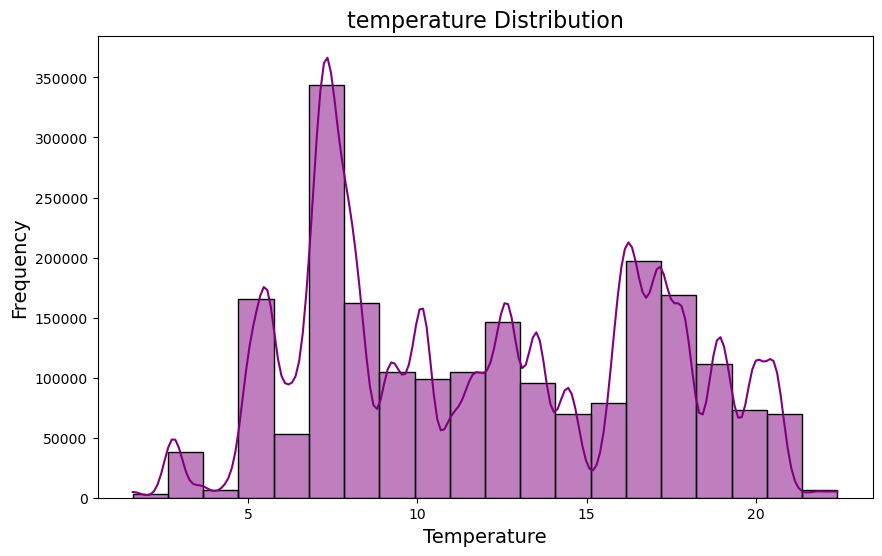

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data['T_MENS'].dropna(), bins=20, kde=True, color='purple')
plt.title('temperature Distribution', fontsize=16)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

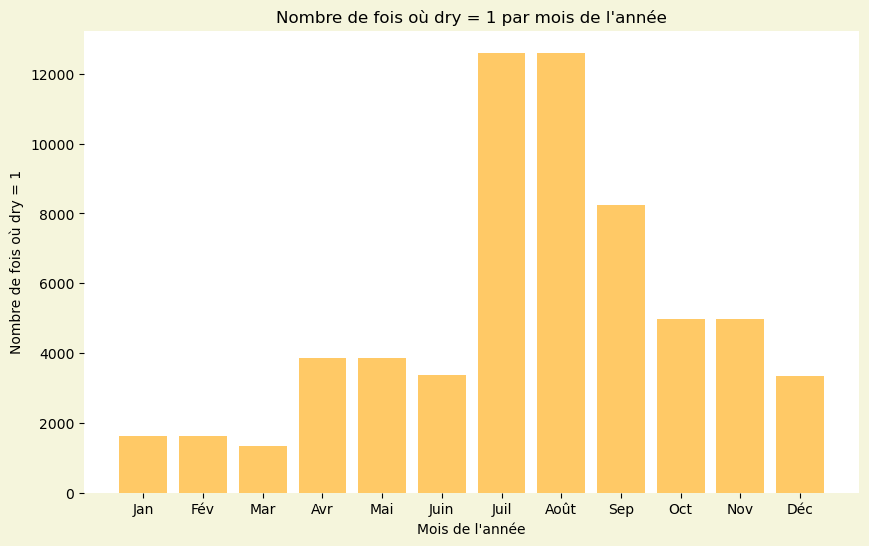

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que `data` soit votre DataFrame

# Convertir `DATE_ville` en datetime s'il ne l'est pas déjà
data['DATE_ville'] = pd.to_datetime(data['DATE_ville'])

# Extraire le mois de `DATE_ville`
data['month'] = data['DATE_ville'].dt.month

# Compter le nombre de fois où `dry` est égal à 1 pour chaque mois
dry_counts_by_month = data[data['dry'] == 1]['month'].value_counts().sort_index()

# Créer un graphique des occurrences de `dry = 1` par mois
plt.figure(figsize=(10, 6), facecolor='beige')
plt.bar(dry_counts_by_month.index, dry_counts_by_month.values, color='orange', alpha=0.6)
plt.xlabel('Mois de l\'année')
plt.ylabel('Nombre de fois où dry = 1')
plt.title('Nombre de fois où dry = 1 par mois de l\'année')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Enlever la grille et les bordures du graphique
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


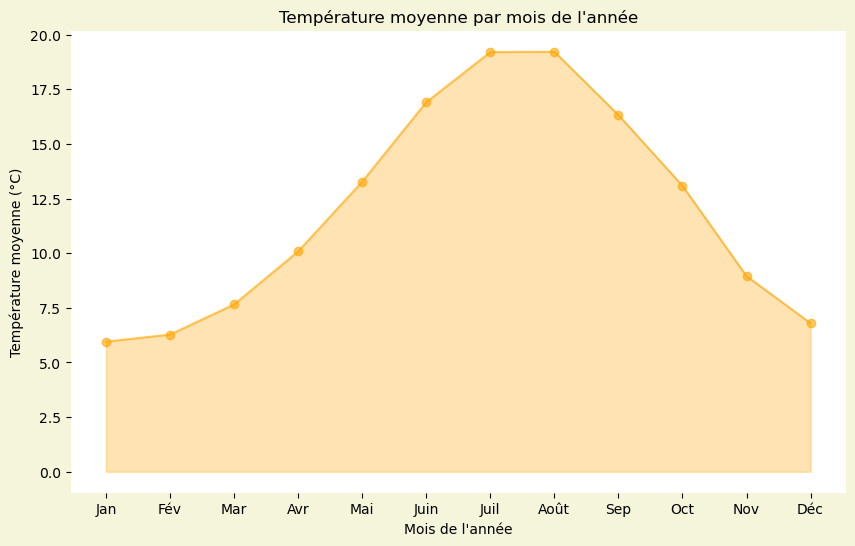

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que `data` soit votre DataFrame

# Convertir `DATE_ville` en datetime s'il ne l'est pas déjà
data['DATE_ville'] = pd.to_datetime(data['DATE_ville'])

# Extraire le mois de `DATE_ville`
data['month'] = data['DATE_ville'].dt.month

# Calculer la température moyenne pour chaque mois
monthly_avg_temp = data.groupby('month')['T_MENS'].mean().sort_index()

# Créer un graphique de la température moyenne par mois
plt.figure(figsize=(10, 6), facecolor='beige')
plt.plot(monthly_avg_temp.index, monthly_avg_temp.values, marker='o', linestyle='-', color='orange', alpha=0.6)
plt.fill_between(monthly_avg_temp.index, monthly_avg_temp.values, color='orange', alpha=0.3)  # Remplir sous la courbe
plt.xlabel('Mois de l\'année')
plt.ylabel('Température moyenne (°C)')
plt.title('Température moyenne par mois de l\'année')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'], fontsize=10)
plt.yticks(fontsize=10)

# Enlever la grille et les bordures du graphique
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()



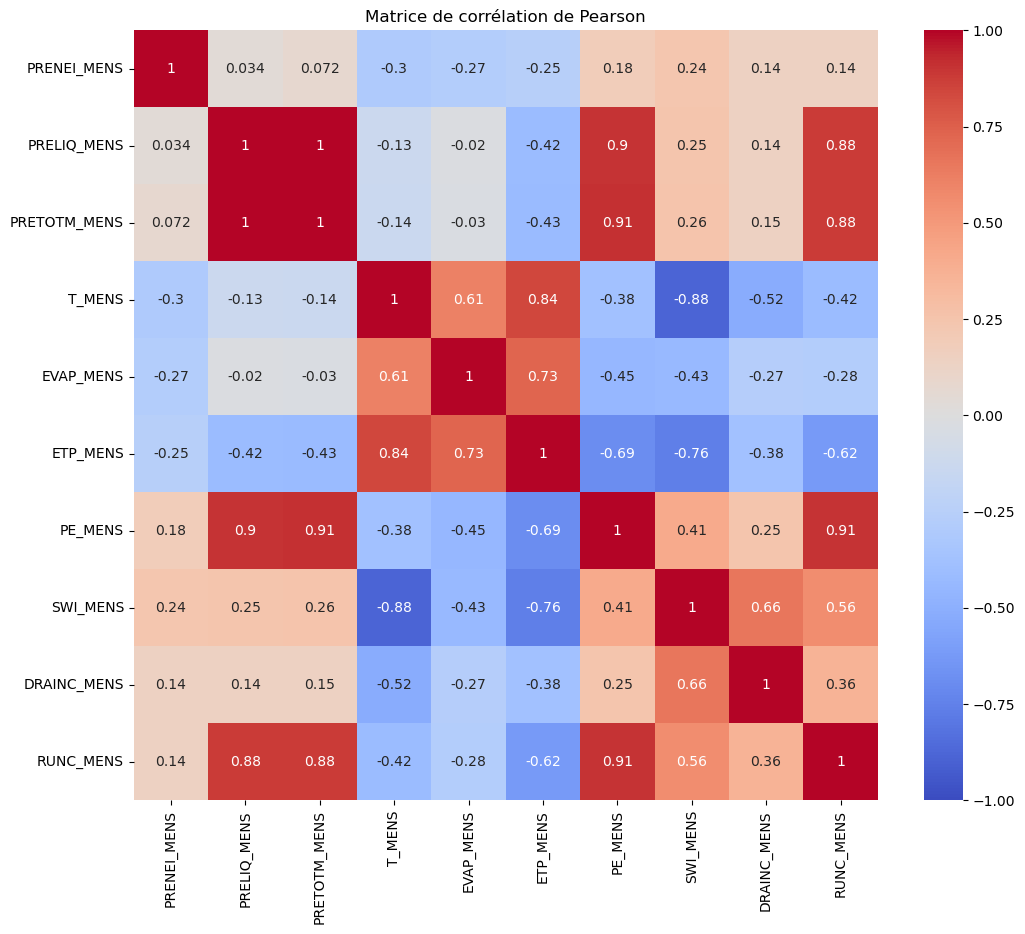

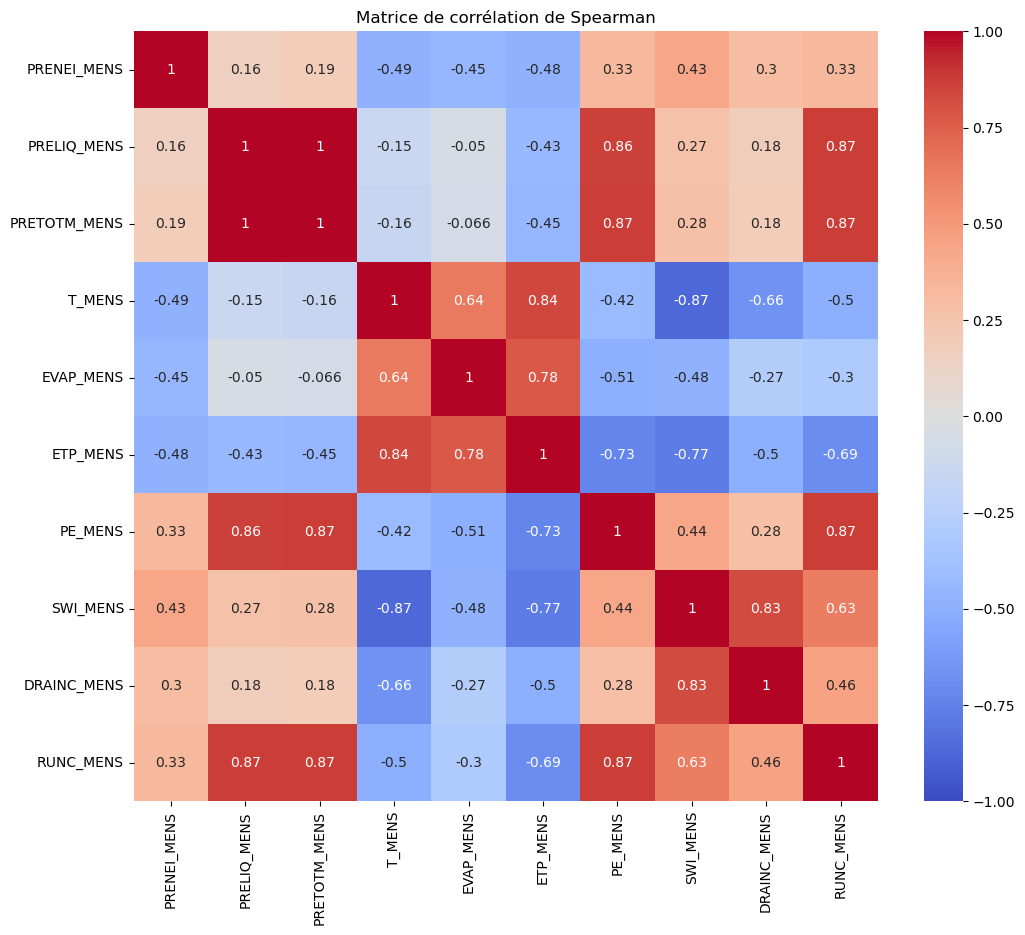

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que `data` soit votre DataFrame

# Sélectionner uniquement les colonnes numériques
numerical_cols = [ 'PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS',
                  'EVAP_MENS', 'ETP_MENS', 'PE_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS']
data_numerical = data[numerical_cols]

# Calculer la matrice de corrélation de Pearson
pearson_corr = data_numerical.corr(method='pearson')

# Calculer la matrice de corrélation de Spearman
spearman_corr = data_numerical.corr(method='spearman')

# Plot de la matrice de corrélation de Pearson
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice de corrélation de Pearson')
plt.show()

# Plot de la matrice de corrélation de Spearman
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice de corrélation de Spearman')
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Define the features and target variable
features = ['PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS', 'EVAP_MENS', 'ETP_MENS', 'SWI_MENS']
X = data[features]  # Features
y = data['dry']     # Target variable (binary: 1 or 0)

# Compute class weights
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}  # Create a dictionary for class weights

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid for the class_weight of class 1 (we will use the balanced weights)
param_grid = {
    'class_weight': [class_weight_dict]  # Using computed balanced weights
}

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the testing data with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Best Parameters: {'class_weight': {0: 0.51533548775166, 1: 16.802057296673716}}
Accuracy: 0.6960425308730273
Confusion Matrix:
 [[283272 123653]
 [  3845   8690]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82    406925
           1       0.07      0.69      0.12     12535

    accuracy                           0.70    419460
   macro avg       0.53      0.69      0.47    419460
weighted avg       0.96      0.70      0.80    419460



=== Entraînement du modèle Random Forest ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs paramètres: {'class_weight': {0: 0.51533548775166, 1: 16.802057296673716}, 'max_depth': None, 'n_estimators': 100}

Score F1: 0.14485687953303858


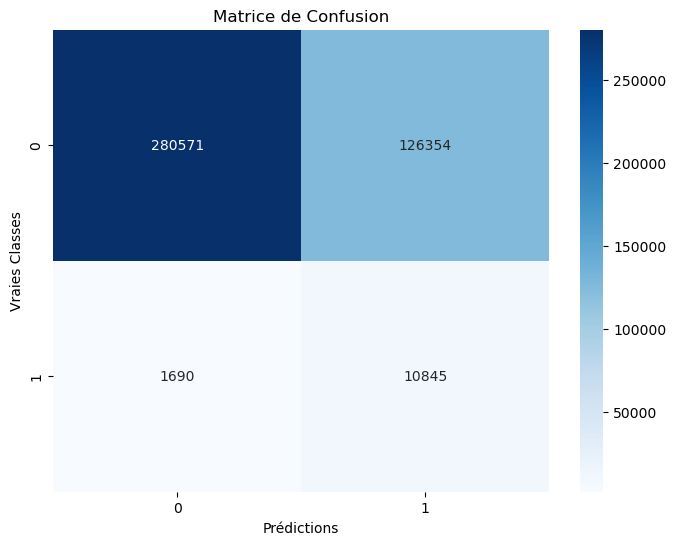

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
# Charger les données
# Remplacez 'data' par votre DataFrame contenant les données.
features = ['PRENEI_MENS', 'PRELIQ_MENS','T_MENS', 'EVAP_MENS', 'ETP_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS']
X = data[features]  # Features
y = data['dry']     # Target variable (binary: 1 or 0)

# Calculer les poids des classes pour équilibrer l'apprentissage
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle Random Forest et la grille de paramètres
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'class_weight': [class_weight_dict],
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}

# Configurer GridSearchCV pour Random Forest
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # Utiliser le score F1 comme métrique
    verbose=1
)

# Entraîner la recherche par grille
print("=== Entraînement du modèle Random Forest ===")
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_rf_model = grid_search.best_estimator_
print(f"Meilleurs paramètres: {grid_search.best_params_}")

# Prédictions
y_pred = best_rf_model.predict(X_test)

# Évaluation
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f"\nScore F1: {f1}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.show()


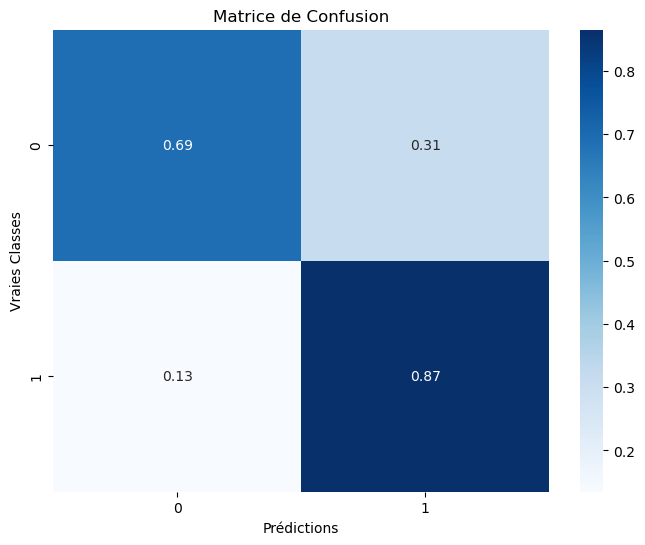

In [14]:
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import time

t = time.time()

# Charger les données
features = ['PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS', 'EVAP_MENS', 'ETP_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS']
X = data[features].values.astype(np.float32)
y = data['dry'].values.astype(np.float32)
groups = data['codgeo'].values

# Calculer les poids des classes pour équilibrer l'apprentissage
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weight_tensor = torch.FloatTensor(class_weights)

# Trier les données par codgeo et temps_ville
data = data.sort_values(by=['codgeo', 'DATE_ville'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, stratify=y, random_state=42)

# Reshape pour LSTM (échantillons, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Assurer la forme correcte des cibles
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Définir le modèle LSTM en PyTorch avec Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, output_size)
   
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

# Calculer le poids positif pour traiter l'asymétrie
pos_weight_value = len(y_train) / sum(y_train) - 1
pos_weight = torch.tensor(pos_weight_value)

# Définir la grille de recherche des hyperparamètres
params = {
    'module__hidden_size': [50, 100],
    'max_epochs': [20],
    'lr': [0.001, 0.01]
}

# Utiliser skorch pour l'intégration avec scikit-learn
net = NeuralNetClassifier(
    LSTMModel,
    module__input_size=X_train.shape[2],
    module__hidden_size=50,
    module__output_size=1,
    optimizer=optim.Adam,
    criterion=nn.BCEWithLogitsLoss(pos_weight=pos_weight),
    iterator_train__shuffle=False,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Configurer GridSearchCV
gs = GridSearchCV(estimator=net, param_grid=params, scoring='f1', cv=GroupKFold(n_splits=5), refit=True, verbose=1)

# Entraîner le modèle en utilisant GridSearchCV
gs.fit(X_train, y_train, groups=groups_train)

# Résultats des prédictions pour chaque modèle dans GridSearchCV
for i, params in enumerate(gs.cv_results_['params']):
    print(f"Model {i + 1} with parameters: {params}")
    y_pred_prob = gs.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)  # Seuil par défaut
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.title(f'Confusion Matrix for Model {i + 1}')
    plt.show()

# Afficher la matrice de confusion et le rapport pour le meilleur modèle
best_model = gs.best_estimator_
y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]

# Ajuster le seuil pour améliorer le rappel
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_best)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]

y_pred_best = (y_pred_prob_best > optimal_threshold).astype(int)

conf_matrix_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_best)
disp_best.plot()
plt.title('Best Model Confusion Matrix')
plt.show()

# Évaluation des résultats du meilleur modèle
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)

print(f"Best Model Parameters: {gs.best_params_}")
print(f"Accuracy: {accuracy_best}")
print(f"F1 Score: {f1_best}")
print(f"Precision: {precision_best}")
print(f"Recall: {recall_best}")

t = time.time() - t
print(f"Total Time: {t}s")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.2725       0.0300        1.2584  41.1734
      2        1.2533       0.0494        1.2396  40.0168
      3        1.2490       0.1280        1.2391  39.6516
      4        1.2478       0.2313        1.2388  39.5728
      5        1.2480       0.2663        1.2349  39.0425
      6        1.2438       0.3166        1.2343  41.8474
      7        1.2428       0.3600        1.2347  41.6383
      8        1.2426       0.4083        1.2346  38.6817
      9        1.2444       0.4084        1.2360  38.9795
     10        1.2433       0.3919        1.2338  39.0170
     11        1.2412       0.4218        1.2332  39.1143
     12        1.2407       0.4685        1.2326  39.2633
     13        1.2408       0.4988        1.2330  38.9578
     14        1.2418       0.5450        1.2468  39.3730
     15     

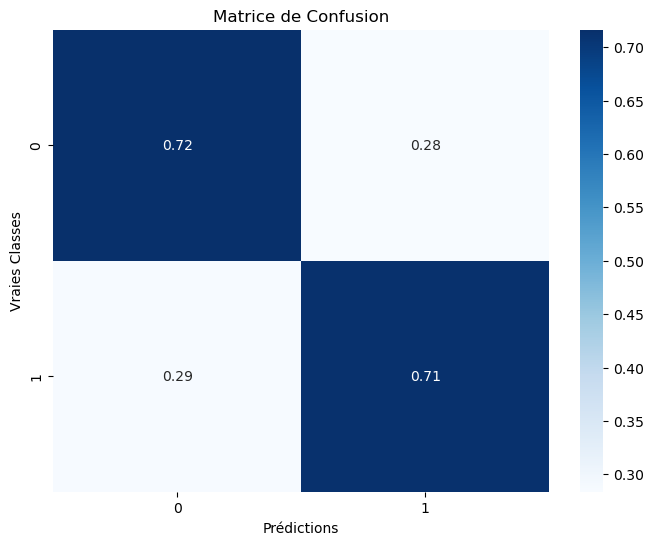

In [58]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.show()